In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

In [2]:
data = sio.loadmat("/mnt/c/Users/ankku/Documents/IITB Lectures and Study Material/Sem6/CS736/assignmentImageDenoising/data/assignmentImageDenoising_brainMRIslice.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jan 26 23:57:15 2021',
 '__version__': '1.0',
 '__globals__': [],
 'brainMRIsliceNoisy': array([[0.05903526, 0.03733414, 0.04083371, ..., 0.03314895, 0.10066028,
         0.10001598],
        [0.19508016, 0.0974471 , 0.06005935, ..., 0.03520444, 0.10372039,
         0.08145106],
        [0.06833413, 0.08346033, 0.11525705, ..., 0.08654534, 0.07535262,
         0.01766324],
        ...,
        [0.0969025 , 0.0194407 , 0.04220045, ..., 0.09017235, 0.04030254,
         0.1183094 ],
        [0.01650911, 0.12580939, 0.09888565, ..., 0.10700805, 0.10666754,
         0.08890157],
        [0.11803197, 0.12742446, 0.11695608, ..., 0.12315155, 0.03446335,
         0.05400686]], shape=(256, 256)),
 'brainMRIsliceOrig': array([[0.02252252, 0.01501502, 0.00750751, ..., 0.04504505, 0.01501502,
         0.01501502],
        [0.03753754, 0.01501502, 0.01501502, ..., 0.01501502, 0.02252252,
         0.04504505],
        [0.022522

In [3]:
noisy_img = data['brainMRIsliceNoisy']
noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
noiseless_img = data['brainMRIsliceOrig']

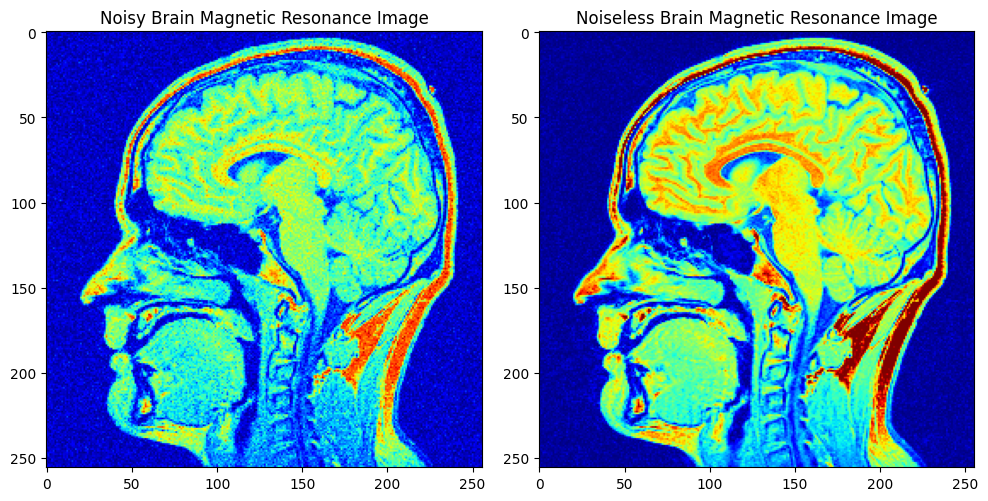

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.abs(noisy_img), cmap='jet')
axes[0].set_title("Noisy Brain Magnetic Resonance Image")

axes[1].imshow(np.abs(noiseless_img), cmap='jet')
axes[1].set_title("Noiseless Brain Magnetic Resonance Image")

plt.tight_layout()
plt.show()

In [5]:
def get_neighbors(img):
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    neighbors = np.stack([np.roll(img, shift, axis) for shift, axis in [(1, 0), (-1, 0), (0, 1), (0, -1)]], axis=0)
    return neighbors

In [6]:
def quadratic_prior(u, param):
    return np.abs(u)**2

In [7]:
def quadratic_prior_grad(u, param):
    return 2*np.abs(u)

In [8]:
def huber_prior(u, delta):
    return np.where(np.abs(u) <= delta, 0.5 * u**2, delta * (np.abs(u) - 0.5 * delta))

In [9]:
def huber_prior_grad(u, delta):
    return np.where(np.abs(u) <= delta, u, delta * np.sign(u))

In [10]:
def discontinuity_adaptive_prior(u, lambda_):
    return lambda_*np.abs(u) - lambda_**2*np.log(1+(np.abs(u)/lambda_))

In [11]:
def discontinuity_adaptive_prior_grad(u, lambda_):
    return lambda_*np.sign(u) - lambda_**2*(1/(1+(np.abs(u)/lambda_)))*(np.sign(u)/lambda_)

In [23]:
def compute_update_quad(img, prior_func_grad, param, weight=0.5):
    neighbors = get_neighbors(img)
    diff = img[None, :, :] - neighbors
    prior_grad = np.mean(prior_func_grad(diff, param), axis=0)
    likelihood_grad = img - noisy_img
    return -weight * likelihood_grad - (1 - weight) * prior_grad

In [24]:
def denoise_image_quad(noisy_img, prior_func, prior_func_grad, param=None, weight=0.5, max_iter=500):
    img = noisy_img.copy()
    obj_values = []
    step_size = 20
    velocity = np.zeros_like(img)
    beta = 0.99
    for i in range(max_iter):
        update = compute_update_quad(img, prior_func_grad, param, weight)
        velocity = beta * velocity + (1 - beta) * update
        img_new = img + step_size * velocity
        img_new = (img_new-img_new.min())/(img_new.max()-img_new.min())

        likelihood_term = np.sum((img_new - noisy_img) ** 2)  # Gaussian noise
        prior_term = np.sum(prior_func(get_neighbors(img_new) - img_new[None, :, :], param))  
        obj_new = -weight * likelihood_term - (1 - weight) * prior_term  # Log posterior
        
        if not obj_values or obj_new > obj_values[-1]:
            step_size *= 1.2  
            img=img_new
            obj_values.append(obj_new)
        else:
            step_size *= 0.4  
    
    return img, obj_values

In [25]:
quad_denoised, quad_obj = denoise_image_quad(noisy_img, quadratic_prior, quadratic_prior_grad, None)
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))
rrmse_noisy = rrmse(noiseless_img, noisy_img)
rrmse_quad = rrmse(noiseless_img, quad_denoised)
print(rrmse_noisy, rrmse_quad)

0.20111204286360113 0.19440971484801192


In [26]:
def compute_update_huber(img, prior_func_grad, param, weight=0.1):
    neighbors = get_neighbors(img)
    diff = img[None, :, :] - neighbors
    # prior_grad = np.mean(prior_func(diff, param), axis=0)
    prior_grad = np.mean(prior_func_grad(diff, param), axis=0)
    likelihood_grad = img - noisy_img
    return -weight * likelihood_grad - (1 - weight) * prior_grad

In [27]:
def denoise_image_huber(noisy_img, prior_func, prior_func_grad, param=None, weight=0.1, max_iter=500):
    img = noisy_img.copy()
    obj_values = []
    step_size = 20
    velocity = np.zeros_like(img)
    beta = 0.99
    for i in range(max_iter):
        # print(i)
        update = compute_update_huber(img, prior_func_grad, param, weight)
        velocity = beta * velocity + (1 - beta) * update
        img_new = img + step_size * velocity
        img_new = (img_new-img_new.min())/(img_new.max()-img_new.min())
        # img_new = img + step_size * update
        # obj_new = np.sum((img_new - noisy_img)**2)  # Log posterior estimation
        likelihood_term = np.sum((img_new - noisy_img)**2)  # Quadratic likelihood (Gaussian noise)
        prior_term = np.sum(prior_func(get_neighbors(img_new) - img_new[None, :, :], param))  # Prior term
        obj_new = -weight * likelihood_term - (1 - weight) * prior_term  # Log posterior
        
        # if obj_new < obj_values[-1] if obj_values else float('inf'):
        # if len(obj_values) > 0:
        #     print(obj_values[-1])
        if not obj_values or obj_new > obj_values[-1]:
            step_size *= 1.2  # Increase step size if improving
            img=img_new
            obj_values.append(obj_new)
        else:
            step_size *= 0.4  # Reduce step size otherwise
            # continue
        
        # obj_values.append(obj_new)
    
    return img, obj_values

In [28]:
def compute_update_disc(img, prior_func_grad, param, weight=0.1):
    neighbors = get_neighbors(img)
    diff = img[None, :, :] - neighbors
    # prior_grad = np.mean(prior_func(diff, param), axis=0)
    prior_grad = np.mean(prior_func_grad(diff, param), axis=0)
    likelihood_grad = img - noisy_img
    return -weight * likelihood_grad - (1 - weight) * prior_grad

In [29]:
def denoise_image_disc(noisy_img, prior_func, prior_func_grad, param=None, weight=0.1, max_iter=500):
    img = noisy_img.copy()
    obj_values = []
    step_size = 20
    velocity = np.zeros_like(img)
    beta = 0.99
    for i in range(max_iter):
        # print(i)
        update = compute_update_disc(img, prior_func_grad, param, weight)
        velocity = beta * velocity + (1 - beta) * update
        img_new = img + step_size * velocity
        img_new = (img_new-img_new.min())/(img_new.max()-img_new.min())
        # img_new = img + step_size * update
        # obj_new = np.sum((img_new - noisy_img)**2)  # Log posterior estimation
        likelihood_term = np.sum((img_new - noisy_img) ** 2)  # Quadratic likelihood (Gaussian noise)
        prior_term = np.sum(prior_func(get_neighbors(img_new) - img_new[None, :, :], param))  # Prior term
        obj_new = -weight * likelihood_term - (1 - weight) * prior_term  # Log posterior
        
        # if obj_new < obj_values[-1] if obj_values else float('inf'):
        # if len(obj_values) > 0:
        #     print(obj_values[-1])
        if not obj_values or obj_new > obj_values[-1]:
            step_size *= 1.2  # Increase step size if improving
            img=img_new
            obj_values.append(obj_new)
        else:
            step_size *= 0.4  # Reduce step size otherwise
            # continue
        
        # obj_values.append(obj_new)
    
    return img, obj_values

In [30]:
params = {'huber': 0.03, 'discont_adaptive': 0.02}
quad_denoised, quad_obj = denoise_image_quad(noisy_img, quadratic_prior, quadratic_prior_grad, None)
huber_denoised, huber_obj = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, params['huber'])
disc_denoised, disc_obj = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, params['discont_adaptive'])
print(f"Quad Denoised:\n {quad_denoised}\n Quad Obj:\n {quad_obj}")
print('\n')
print(f"Huber Denoised:\n {huber_denoised}\n Huber Obj:\n {huber_obj}")
print('\n')
print(f"Disc Denoised:\n {disc_denoised}\n Disc Obj:\n {disc_obj}")


Quad Denoised:
 [[0.07025744 0.05458145 0.06009526 ... 0.0539616  0.11027896 0.1099973 ]
 [0.17841535 0.10744191 0.07684795 ... 0.05748365 0.11460273 0.09392795]
 [0.07903772 0.09821433 0.11904037 ... 0.09933215 0.09057021 0.03674854]
 ...
 [0.10394353 0.04057656 0.06224832 ... 0.10318763 0.05942601 0.12565561]
 [0.03604649 0.12903573 0.10860362 ... 0.1172575  0.11193635 0.1009146 ]
 [0.12016252 0.13112443 0.12246649 ... 0.12698873 0.05281461 0.07156226]]
 Quad Obj:
 [np.float64(-640.7727443286964), np.float64(-639.9826808594482), np.float64(-639.9826808594479)]


Huber Denoised:
 [[0.05693067 0.04462953 0.03649874 ... 0.03677298 0.0450241  0.04976855]
 [0.07047288 0.04827108 0.03831818 ... 0.03364185 0.05216861 0.04506533]
 [0.05643265 0.04614674 0.04353448 ... 0.04199785 0.04857529 0.04066484]
 ...
 [0.03661793 0.03181498 0.03039275 ... 0.05372085 0.02353616 0.05991608]
 [0.037512   0.05015205 0.04279235 ... 0.05547081 0.0358575  0.0503439 ]
 [0.05202319 0.05454932 0.04521175 ... 0.0

In [31]:
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))
rrmse_noisy = rrmse(noiseless_img, noisy_img)
rrmse_quad = rrmse(noiseless_img, quad_denoised)
rrmse_huber = rrmse(noiseless_img, huber_denoised)
rrmse_disc = rrmse(noiseless_img, disc_denoised)
print(rrmse_noisy, rrmse_quad, rrmse_huber, rrmse_disc)

0.20111204286360113 0.19440971484801192 0.13924112316237142 0.1439074215717626


In [35]:
'''Used it for fine tuning'''

# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.01, 0.1, 10):  # Try different values
#     denoised_img, _ = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter: ", best_param)
# print("Optimal RRMSE: ", best_rrmse)

'Used it for fine tuning'

In [36]:
'''Used it for fine tuning'''

#  best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.1, 1, 10):  # Try different values
#     denoised_img, _ = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, params['huber'], p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter: ", best_param)
# print("Optimal RRMSE: ", best_rrmse)

'Used it for fine tuning'

In [37]:
'''Used it for fine tuning'''

# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.01, 0.1, 10):  # Try different values
#     denoised_img, _ = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter: ", best_param)
# print("Optimal RRMSE: ", best_rrmse)

'Used it for fine tuning'

In [38]:
'''Used it for fine tuning'''

# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.1, 1, 10):  # Try different values
#     denoised_img, _ = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, params['huber'], p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter: ", best_param)
# print("Optimal RRMSE: ", best_rrmse)

'Used it for fine tuning'

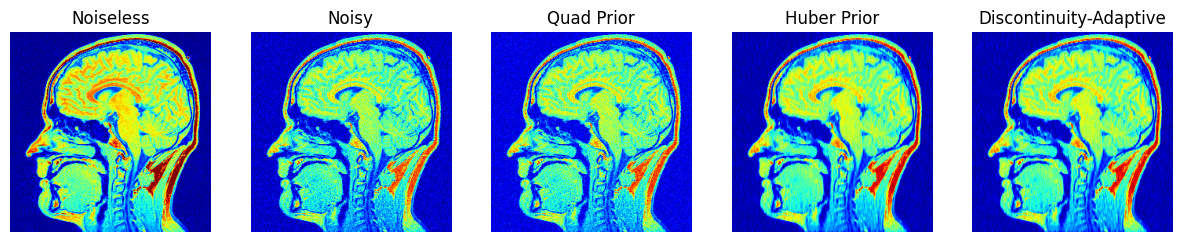

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for ax, img, title in zip(axs, [noiseless_img, noisy_img, quad_denoised, huber_denoised, disc_denoised],
                          ['Noiseless', 'Noisy', 'Quad Prior', 'Huber Prior', 'Discontinuity-Adaptive']):
    ax.imshow(np.abs(img), cmap='jet')
    ax.set_title(title)
    ax.axis('off')
plt.show()

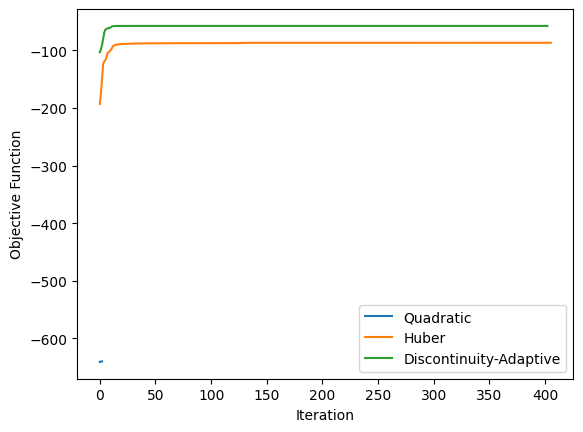

In [34]:
plt.figure()
plt.plot(quad_obj, label='Quadratic')
plt.plot(huber_obj, label='Huber')
plt.plot(disc_obj, label='Discontinuity-Adaptive')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.show()